In [1]:
import json
import os, glob

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfs = tf.contrib.summary
tfe = tf.contrib.eager

import sonnet as snt
import numpy as np
from functools import reduce

from utils import is_valid_file, setup_eager_checkpoints_and_restore

tf.enable_eager_execution()

W0706 22:37:52.715366 139689796065024 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0706 22:37:52.731045 139689796065024 deprecation_wrapper.py:119] From /homes/gf332/Documents/projects/VAEs/vae_venv/lib/python3.7/site-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
def mnist_input_fn(data, batch_size=256, shuffle_samples=5000):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(shuffle_samples)
    dataset = dataset.map(mnist_parse_fn)
    dataset = dataset.batch(batch_size)

    return dataset


def mnist_parse_fn(data):
    return tf.cast(data, tf.float32) / 255.


optimizers = {
    "sgd": tf.train.GradientDescentOptimizer,
    "momentum": lambda lr:
                    tf.train.MomentumOptimizer(learning_rate=lr,
                                               momentum=0.9,
                                               use_nesterov=True),
    "adam": tf.train.AdamOptimizer,
    "rmsprop": tf.train.RMSPropOptimizer
}

In [3]:
class ManifoldVAE(snt.AbstractModule):
    
    def __init__(self, 
                 latent_dim=32, 
                 name="manifold_vae"):
        
        super(ManifoldVAE, self).__init__(name=name)
        
        self.latent_dim = latent_dim
        self.is_training = True
        
        
    @property
    def kl_divergence(self):
        """
        Calculates the KL divergence between the current variational posterior and the prior:

        KL[ q(z | theta) || p(z) ]

        """
        self._ensure_is_connected()
        
        return tfd.kl_divergence(self.latent_posterior, self.latent_prior)
    
    @property
    def log_prob(self):
        return tf.reduce_sum(self._log_prob)
    
    
    @snt.reuse_variables
    def encode(self, inputs, test_local_stats=True):
        """
        Builds the encoder part of the VAE, i.e. q(x | theta).
        This maps from the input to the latent representation.
        """

        # ----------------------------------------------------------------
        # Define Layers
        # ----------------------------------------------------------------
        self.encoder_layers = [
            snt.BatchReshape((28, 28, 1)),
            snt.Conv2D(output_channels=64,
                       kernel_shape=(5, 5),
                       stride=2,
                       name="encoder_conv1"),
            tf.nn.leaky_relu,
            snt.Conv2D(output_channels=128,
                       kernel_shape=(5, 5),
                       stride=2,
                       use_bias=False,
                       name="encoder_conv2"),
            tf.keras.layers.BatchNormalization(),
            tf.nn.leaky_relu,
            snt.BatchFlatten(),
            snt.Linear(output_size=1024,
                       use_bias=False,
                       name="encoder_linear1"),
            tf.keras.layers.BatchNormalization(),
            tf.nn.leaky_relu
        ]
        
        self.encoder_loc_head = snt.Linear(output_size=self.latent_dim,
                                           name="encoder_loc_head")
        self.encoder_log_scale_head = snt.Linear(output_size=self.latent_dim,
                                                 name="encoder_log_scale_head")
        
        # ----------------------------------------------------------------
        # Apply Layers
        # ----------------------------------------------------------------

        activations = inputs
        
        for layer in self.encoder_layers:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                activations = layer(activations, 
                                    training=self.is_training)
                
            else:
                activations = layer(activations)
            
        # Get latent posterior statistics
        loc = self.encoder_loc_head(activations)
        scale = 1e-6 + tf.nn.softplus(self.encoder_log_scale_head(activations))
        
        # Create latent posterior
        self.latent_posterior = tfd.Normal(loc=loc, scale=scale)
        
        return self.latent_posterior.sample()


    @snt.reuse_variables
    def decode(self, latent_code, test_local_stats=True):
        """
        Builds the decoder part of the VAE
        """
        # ----------------------------------------------------------------
        # Define Layers
        # ----------------------------------------------------------------
        
        self.decoder_levels = [self.encoder_loc_head.transpose()]
        
        for layer in self.encoder_layers[::-1]:
            
            # Some layers need care for reversing
            if isinstance(layer, snt.Transposable):
                layer = layer.transpose()
                
            elif isinstance(layer, snt.BatchFlatten):
                layer = BatchReshape((28, 28, 1))
                
            elif isinstance(layer, snt.BatchReshape):
                continue
           
            # Add layer
            self.decoder_levels.append(layer)
        
        
        # ----------------------------------------------------------------
        # Apply Layers
        # ----------------------------------------------------------------

        # Create prior
        self.latent_prior = tfd.Normal(loc=tf.zeros_like(latent_code),
                                       scale=tf.ones_like(latent_code))
        
        activations = latent_code
        
        for layer in self.decoder_levels:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                activations = layer(activations, 
                                    training=self.is_training)

            else:
                activations = layer(activations)
        
        return tf.nn.sigmoid(activations)
    
    
    def _build(self, inputs, test_local_stats=True):
        """
        Build standard VAE:
        1. Encode input -> latent mu, sigma
        2. Sample z ~ N(z | mu, sigma)
        """
        
        reshaper = snt.BatchReshape((28, 28, 1))
        inputs = reshaper(inputs)
        
        # Code the latents on the first stage
        latents = self.encode(inputs, test_local_stats=test_local_stats)
        
        # Reconsturct image from the latents
        reconstruction = self.decode(latents, test_local_stats=test_local_stats)
        
        self.log_gamma = tf.get_variable("log_gamma_x", [], tf.float32, tf.zeros_initializer())
        self.likelihood = tfd.Normal(loc=reconstruction,
                                     scale=tf.exp(self.log_gamma))
        self._log_prob = self.likelihood.log_prob(inputs)
        
        return reconstruction

In [7]:
def run(config, model_dir, is_training, train_first_stage=True):

    num_batches = config["num_training_examples"] // config["batch_size"] + 1
  
    print("Configuration:")
    print(json.dumps(config, indent=4, sort_keys=True))

    # ==========================================================================
    # Load dataset
    # ==========================================================================

    ((train_data, _),
     (eval_data, _)) = tf.keras.datasets.mnist.load_data()

    # ==========================================================================
    # Create model
    # ==========================================================================

#     g = tf.get_default_graph()
    
    with tf.Graph().as_default():
    
        vae = ManifoldVAE(latent_dim=64)
        vae(tf.zeros((1, 28, 28)))
        
        optimizer = optimizers[config["optimizer"]](config["learning_rate"])

        # ==========================================================================
        # Define Checkpoints
        # ==========================================================================

        global_step = tf.train.get_or_create_global_step()

        trainable_vars = vae.get_all_variables() + (global_step,)
        checkpoint_dir = os.path.join(model_dir, "checkpoints")

        checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
            variables=trainable_vars,
            checkpoint_dir=checkpoint_dir,
            checkpoint_name=config["checkpoint_name"])

        # ==========================================================================
        # Define Tensorboard Summary writer
        # ==========================================================================

        logdir = os.path.join(model_dir, "log")
        writer = tfs.create_file_writer(logdir)
        writer.set_as_default()

        # ==========================================================================
        # Train the model
        # ==========================================================================

        if is_training:

            if train_first_stage:
                beta = config["beta1"]

                for epoch in range(1, config["num_epochs"] + 1):

                    dataset = mnist_input_fn(data=train_data,
                                            batch_size=config["batch_size"])

                    with tqdm(total=num_batches) as pbar:
                        for batch in dataset:
                            # Increment global step
                            global_step += 1

                            # Record gradients of the forward pass
                            with tf.GradientTape() as tape, tfs.record_summaries_every_n_global_steps(config["log_freq"]):

                                output = vae(batch)

                                kl = vae.kl_divergence
                                total_kl = tf.reduce_sum(kl)

                                log_prob = vae.log_prob

                                warmup_coef = tf.minimum(1., global_step.numpy() / (config["warmup"] * num_batches))

                                # negative ELBO
                                loss = total_kl - beta * warmup_coef * log_prob 

                                output = tf.cast(output, tf.float32)

                                # Add tensorboard summaries
                                tfs.scalar("Loss", loss)
                                tfs.scalar("Total_KL", kl)
                                tfs.scalar("Max_KL", tf.reduce_max(kl))
                                tfs.scalar("Log-Probability", log_prob)
                                tfs.scalar("Warmup_Coef", warmup_coef)
                                tfs.scalar("Gamma-x", tf.exp(vae.log_gamma))
                                tfs.image("Reconstruction", output)

                            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                            print(update_ops)

                            return

                            # Backprop
                            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                                grads = tape.gradient(loss, vae.get_all_variables())
                                optimizer.apply_gradients(zip(grads, vae.get_all_variables()))

                            # Update the progress bar
                            pbar.update(1)
                            pbar.set_description("Epoch {}, ELBO: {:.2f}".format(epoch, loss))

                    checkpoint.save(ckpt_prefix)

                tfs.flush(writer)
                print("First Stage Training Complete!")
            
    tfs.graph(g)
    return vae

In [8]:
MODEL_DIR = "/tmp/2-stage-vae-v2/"

config = {
        "num_training_examples": 60000,
        "batch_size": 250,
        "num_epochs": 10,
        "num_epochs_stage_2": 5,
        
        "beta1": 0.1,
        "beta2": 0.1,
        "warmup": 10.,
        
        "learning_rate": 1e-3,
        
        "optimizer": "adam",
        
        "checkpoint_name": "_ckpt",
        "log_freq": 100,
    }

In [9]:
vae = run(config, model_dir=MODEL_DIR, is_training=True, train_first_stage=True)

Configuration:
{
    "batch_size": 250,
    "beta1": 0.1,
    "beta2": 0.1,
    "checkpoint_name": "_ckpt",
    "learning_rate": 0.001,
    "log_freq": 100,
    "num_epochs": 10,
    "num_epochs_stage_2": 5,
    "num_training_examples": 60000,
    "optimizer": "adam",
    "warmup": 10.0
}
No checkpoint found!


W0706 22:38:40.863915 139689796065024 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


ValueError: Trainable variable created when calling a template after the first time, perhaps you used tf.Variable when you meant tf.get_variable: [<tf.Variable 'manifold_vae_1/manifold_vae/encode/batch_normalization_2/gamma:0' shape=(128,) dtype=float32>, <tf.Variable 'manifold_vae_1/manifold_vae/encode/batch_normalization_2/beta:0' shape=(128,) dtype=float32>, <tf.Variable 'manifold_vae_1/manifold_vae/encode/batch_normalization_3/gamma:0' shape=(1024,) dtype=float32>, <tf.Variable 'manifold_vae_1/manifold_vae/encode/batch_normalization_3/beta:0' shape=(1024,) dtype=float32>]

originally defined at:
  File "<ipython-input-7-dcd14f9abfbe>", line 23, in run
    vae = ManifoldVAE(latent_dim=64)
  File "<ipython-input-3-76f556e2b9ad>", line 7, in __init__
    super(ManifoldVAE, self).__init__(name=name)
  File "/homes/gf332/Documents/projects/VAEs/vae_venv/lib/python3.7/site-packages/sonnet/python/modules/base.py", line 180, in __init__
    custom_getter_=self._custom_getter)
  File "/homes/gf332/Documents/projects/VAEs/vae_venv/lib/python3.7/site-packages/tensorflow/python/ops/template.py", line 160, in make_template
    **kwargs)


In [52]:
((train_data, _),
(eval_data, _)) = tf.keras.datasets.mnist.load_data()

vae.is_training = False

(1, 28, 28)
False


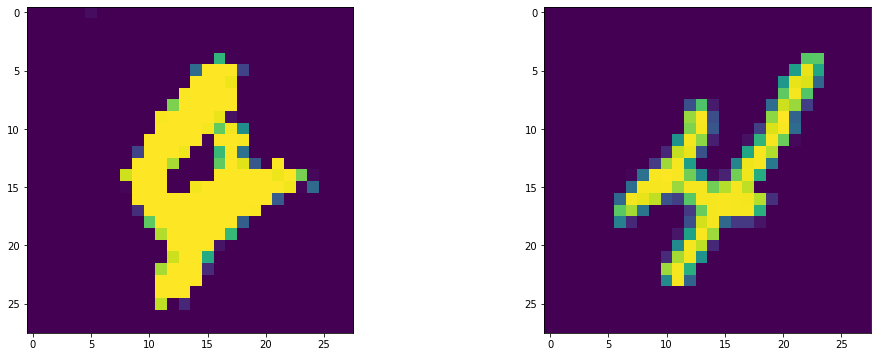

In [53]:
z = vae.latent_posterior.sample()
test_im = mnist_parse_fn(train_data[9])
z_ = vae.encode(test_im[tf.newaxis, ...], test_local_stats=False)

im = vae.decode(z, test_local_stats=False)
print(im.shape)
im = tf.squeeze(im).numpy()

print(vae.is_training)

plt.figure(figsize=(17,6))
plt.subplot(121)
plt.imshow(im)

plt.subplot(122)
plt.imshow(test_im)

In [54]:
print(z)
print(z_)

tf.Tensor(
[[ 0.5966993   0.24020544 -1.0628476  -0.27744395 -0.62909436  0.3334056
  -1.4285717  -0.4879048   1.1275315  -0.4965166   1.4587637  -0.42441043
   0.3963925   1.0481342   0.23841102 -0.37203413  1.2964473  -0.9027144
   1.2561873   0.7882661  -1.1573831  -1.7816384  -1.3260957   0.7349494
   0.9542781  -0.7522101  -0.05666764  0.0938426   0.16593735 -0.12231594
   0.76784265 -0.00784632  0.8623152  -0.93366295 -0.12255742  0.6166265
   0.4171484  -0.00670139 -0.0830364   0.14931692 -1.0290347   0.35885155
  -0.44689992  1.1856756   0.9066683  -0.7671778  -0.48246858 -0.547666
  -1.4224062  -1.355649   -0.49032408 -0.21278995 -0.5402432  -0.0758155
   0.3474331  -1.2097613  -0.40928254 -1.384895    1.6998756   0.20649637
  -0.12069284  0.2758879   0.4624661   0.51384795]], shape=(1, 64), dtype=float32)
tf.Tensor(
[[ 3.9798164e+00  2.7631283e+00 -5.5554042e+00  2.0732424e+01
  -1.1920581e+01  1.9174673e+01 -4.6818151e+00  6.5271020e+00
   1.6129889e+01 -3.9901242e-01 -3.211

In [23]:
test_im

<tf.Tensor: id=1927559, shape=(28, 28), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 

In [26]:
im

array([[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        3.5376430e-02, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 1.000000

In [40]:
z

<tf.Tensor: id=1929653, shape=(1, 64), dtype=float32, numpy=
array([[-0.5581691 ,  0.01775781, -0.6093106 , -1.0657898 , -0.63679683,
        -0.16028693,  0.02292752,  0.7399033 , -0.5489996 , -0.49665543,
        -1.0602268 , -1.6546901 ,  0.34913424, -0.19600882,  1.0969449 ,
        -0.4485845 ,  1.6164017 , -0.48646978,  0.5601295 ,  0.2864341 ,
        -0.78044325,  1.0218213 , -0.2592898 , -0.8651161 ,  0.24365303,
        -0.06692692,  0.11266441,  0.280285  , -0.8611255 , -0.83919936,
        -0.8793286 ,  0.26535162,  0.5393854 ,  0.4650734 , -1.1195016 ,
        -0.3236745 ,  0.15036449,  0.5745703 , -0.00505354,  0.09977586,
        -0.2344154 , -0.07438146, -1.6192576 , -0.76564246, -0.23782364,
         0.07905169, -0.86064935, -0.7772483 ,  0.03899552, -1.4230525 ,
         0.38040376,  0.6333171 ,  0.0978348 ,  0.8511952 ,  1.3628192 ,
        -0.39277148, -0.10434239, -0.5582481 , -0.6518381 ,  0.26644206,
        -0.81384236, -0.05203085,  0.06435593, -0.2363559 ]],
 